## Naive Bayes Modeling and some EDA using: 
### - Transformer: CountVectorizer
### - Lemmatized words

In [1]:
# Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Naive Bayes 
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

# Other Sklearn 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score, classification_report

# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# NLP imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# nltk.download()  --> Download all, and then restart jupyter lab
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, pos_tag
import re

### Loading Data and Splitting Data

In [2]:
# Load the data
df = pd.read_csv('../../../data/clean_data/clean_posts.csv', index_col=0)
df.head()

,subreddit,title,created_utc,selftext,title_selftext,author,media_only,permalink,text_length,clean_text_stem,clean_text_lem
0,tolkienfans,What happened to Tolkien’s Red Book?,1616977706,I was wondering if somebody could clear up my ...,what happened to tolkien s red book i was wond...,lukeskinwalker69epic,False,/r/tolkienfans/comments/mfdrms/what_happened_t...,322,happen tolkien red book wonder somebodi could ...,happened tolkien red book wondering somebody c...
1,tolkienfans,What Makes People Turn Invisible When the Put ...,1616971688,I guess this is a big question because I never...,what makes people turn invisible when the put ...,Jpmaniax26,False,/r/tolkienfans/comments/mfbzjh/what_makes_peop...,252,make peopl turn invis put one ring guess big q...,make people turn invisible put one ring guess ...
2,tolkienfans,"Theory: At some point not told in the Tale, Ar...",1616971077,This is the last dialogue between Queen Undómi...,theory at some point not told in the tale arag...,yew_eater,False,/r/tolkienfans/comments/mfbsks/theory_at_some_...,6045,theori point told tale aragorn arwen must seri...,theory point told tale aragorn arwen must seri...
3,tolkienfans,I’d like to purchase a matching set of books o...,1616969977,Can anyone help me out? Looking for matching b...,i d like to purchase a matching set of books o...,GoosePants72,False,/r/tolkienfans/comments/mfbfyj/id_like_to_purc...,302,like purchas match set book everyth lotr silma...,like purchase matching set book everything lot...
4,tolkienfans,"When Faramir ‘proposes’ to Eowyn, something we...",1616966528,After he confesses his love for her and talks ...,when faramir proposes to eowyn something weird...,PhendranaDrifter,False,/r/tolkienfans/comments/mfaae8/when_faramir_pr...,731,faramir propos eowyn someth weird happen confe...,faramir proposes eowyn something weird happens...


In [3]:
# Checks baseline
df['subreddit'].value_counts(normalize=True)
# df['subreddit'].value_counts()

tolkienfans    0.516823
harrypotter    0.483177
Name: subreddit, dtype: float64

In [5]:
# Set up X and y
X = df['clean_text_lem']
y = df['subreddit']

In [6]:
# Splits the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y,
                                                    random_state=42)

### Modeling Naive Bayes

In [8]:
# Baseline accuracy 
y_test.value_counts(normalize=True)

tolkienfans    0.516821
harrypotter    0.483179
Name: subreddit, dtype: float64

#### First Iteration

In [9]:
# Instantiates a pipeline 
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [10]:
# Creates the pipe parameters 
pipe_params = {
    'cvec__max_features': [1000, 2000, 3000],
    'cvec__min_df':[1],
    'cvec__max_df':[0.70, 0.75, 0.80, 0.85],
    'cvec__ngram_range':[(1,1), (1,2), (1,3)]
}

In [11]:
# Instantiates the GridSearchCV
gs = GridSearchCV(pipe, 
                param_grid=pipe_params,
                cv=5, 
                verbose=1, 
                n_jobs=4)

In [12]:
# Fits GridSearch to training data
gs.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   45.2s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:  3.4min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=4,
             param_grid={'cvec__max_df': [0.7, 0.75, 0.8, 0.85],
                         'cvec__max_features': [1000, 2000, 3000],
                         'cvec__min_df': [1],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             verbose=1)

In [14]:
gs.best_score_

0.9651619375073534

In [15]:
train1, test1 = gs.score(X_train, y_train), gs.score(X_test, y_test)
train1, test1

(0.9674751156596103, 0.9667788057190917)

In [16]:
gs.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': 3000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1)}

#### Second Iteration - with adjusted GridSearch Parameters

In [56]:
# Instantiates a pipeline 
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [57]:
# Creates the pipe parameters 
pipe_params = {
    'cvec__max_features': [1000, 2000, 3000],
    'cvec__min_df':[1],
    'cvec__max_df':[0.70, 0.80, 0.85],
    'cvec__ngram_range':[(1,1), (1,2), (1,3)]
}

In [58]:
# Instantiates the GridSearchCV
gs = GridSearchCV(pipe, 
                param_grid=pipe_params,
                cv=5, 
                verbose=1, 
                 n_jobs=4)

In [59]:
# Fits GridSearch to training data
gs.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   54.7s
[Parallel(n_jobs=4)]: Done 135 out of 135 | elapsed:  3.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=4,
             param_grid={'cvec__max_df': [0.7, 0.8, 0.85],
                         'cvec__max_features': [1000, 2000, 3000],
                         'cvec__min_df': [1],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             verbose=1)

In [60]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9674751156596103, 0.9667788057190917)

In [61]:
gs.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': 3000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1)}

#### Third Iteration - with adjusted GridSearch Parameters

In [62]:
# Instantiates a pipeline 
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [64]:
# Creates the pipe parameters 
pipe_params = {
    'cvec__max_features': [2000, 3000, 4000],
    'cvec__min_df':[1],
    'cvec__max_df':[0.60, 0.65, 0.70, 0.75],
    'cvec__ngram_range':[(1,1), (1,2)]
}

In [65]:
# Instantiates the GridSearchCV
gs = GridSearchCV(pipe, 
                param_grid=pipe_params,
                cv=5, 
                verbose=1, 
                 n_jobs=4)

In [66]:
# Fits GridSearch to training data
gs.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   29.1s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:  1.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=4,
             param_grid={'cvec__max_df': [0.6, 0.65, 0.7, 0.75],
                         'cvec__max_features': [2000, 3000, 4000],
                         'cvec__min_df': [1],
                         'cvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [67]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9699285013318379, 0.9657275021026073)

In [68]:
gs.best_params_

{'cvec__max_df': 0.6,
 'cvec__max_features': 4000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2)}

#### Evaulation using the Best Parameters = First Iteration

In [17]:
# prints the first iteration training and test scores again
train1, test1 = gs.score(X_train, y_train), gs.score(X_test, y_test)
train1, test1

(0.9674751156596103, 0.9667788057190917)

In [18]:
# Calculates the y predictions and the AUC score
y_preds = gs.predict(X_test)
auc = roc_auc_score(y_test, gs.predict_proba(X_test)[:,1])

In [19]:
# Creates the row dataframe of model metrics to be added to the final model metrics table for the presentation
results = pd.DataFrame({'Model': ['Multinomial NB'], 
                        'Transformer': ['CountVectorizer'],
                        'Stemmed/Lemmed': ['Lemmatized'],
                        'Train_acc': [train1],
                        'Test_acc': [test1], 
                        'AUC': [auc]})
results.to_csv('../../../data/result_scores/nb_countvec_lem.csv')

In [20]:
results

,Model,Transformer,Stemmed/Lemmed,Train_acc,Test_acc,AUC
0,Multinomial NB,CountVectorizer,Lemmatized,0.967475,0.966779,0.997227


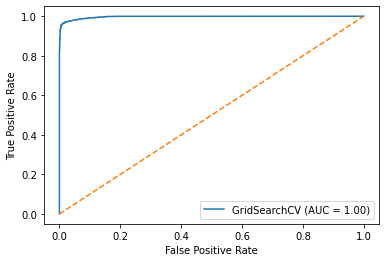

In [21]:
# Plots the ROC curve so that the AUC curve could be visualized
plot_roc_curve(gs, X_test, y_test)
plt.plot([0,1],[0,1], label='baseline', linestyle='--');

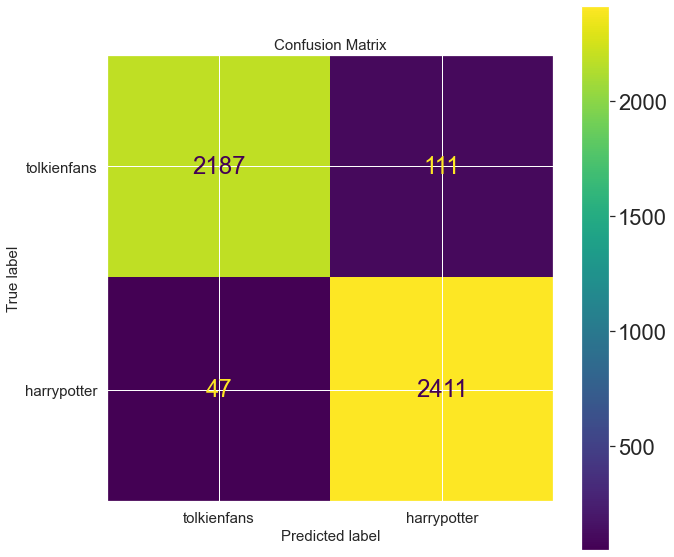

In [22]:
# Creates the confusion matrix and exports it as an image
sns.set(font_scale=2.0)
cm = confusion_matrix(y_test, y_preds)
fig, ax = plt.subplots(figsize=(10, 10))
plot = ConfusionMatrixDisplay(cm).plot(ax=ax)
plot
plt.title('Confusion Matrix')
ax.set_title('Confusion Matrix', fontdict={'size':'15'})
ax.set_xticklabels(df['subreddit'].unique(), size=15);
ax.set_yticklabels(df['subreddit'].unique(), size=15);
ax.set_xlabel('Predicted label', fontdict={'size':'15'})
ax.set_ylabel('True label', fontdict={'size':'15'})

plt.savefig('../../../presentation/imgs/cm_nb_countvec_lem.jpg')

In [23]:
# Creates the coef dictionary dataframe and outputs the 10 smallest coefficients
coefs = gs.best_estimator_.named_steps['nb'].coef_
coefs = coefs.ravel()

names = gs.best_estimator_.named_steps['cvec'].get_feature_names()

coef_dict = pd.DataFrame({'coefs': coefs,
                      'features': pd.Series(names)})
coef_dict.nsmallest(10, columns=['coefs'])

,coefs,features
45,-12.879785,9d
106,-12.879785,albus
155,-12.879785,animagus
175,-12.879785,apparate
245,-12.879785,auror
249,-12.879785,avada
260,-12.879785,azkaban
283,-12.879785,barty
288,-12.879785,basilisk
318,-12.879785,bella


In [24]:
# Outputs the 10 largest coefficients
coef_dict.nlargest(10, columns=['coefs'])

,coefs,features
2711,-4.333615,tolkien
2973,-4.491562,would
2250,-4.562507,ring
1882,-4.803269,one
1575,-4.842565,like
364,-4.931046,book
1511,-4.972501,know
2302,-5.008855,sauron
850,-5.123589,elf
2142,-5.158879,read
